In [156]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_rows', None)
import warnings
warnings.filterwarnings("ignore")

# working with dates
from datetime import datetime

# modeling
import statsmodels.api as sm
from statsmodels.tsa.api import Holt, ExponentialSmoothing

# evaluate
from sklearn.metrics import mean_squared_error
from math import sqrt 

In [157]:
df1=pd.read_csv('GlobalLandTemperaturesByCity.csv')

In [158]:
df1.isna().sum()

dt                                    0
AverageTemperature               364130
AverageTemperatureUncertainty    364130
City                                  0
Country                               0
Latitude                              0
Longitude                             0
dtype: int64

In [159]:
df1.City.value_counts()

Springfield                  9545
Worcester                    8359
León                         7469
Rongcheng                    6526
Cambridge                    6478
Columbus                     6478
Syracuse                     6478
Brest                        6478
Birmingham                   6478
London                       6478
Manchester                   6478
Saint Petersburg             6478
Santiago                     6203
Aurora                       6101
Alexandria                   5908
Arlington                    5564
Barcelona                    5516
Valencia                     5516
Kingston                     5516
Cartagena                    5516
Salamanca                    5384
Peoria                       5384
Córdoba                      5274
Lalitpur                     5226
Jamalpur                     5226
Bharatpur                    5226
Hyderabad                    5226
Saint Louis                  5216
Richmond                     5216
Toledo        

In [160]:
df= df1[df1['City']=='Bat Yam']
df.head()

dt  AverageTemperature  AverageTemperatureUncertainty  \
735366  1808-10-01              21.717                          1.850   
735367  1808-11-01              17.754                          2.246   
735368  1808-12-01              11.711                          2.105   
735369  1809-01-01              10.408                          2.949   
735370  1809-02-01              11.631                          2.870   

           City Country Latitude Longitude  
735366  Bat Yam  Israel   31.35N    33.93E  
735367  Bat Yam  Israel   31.35N    33.93E  
735368  Bat Yam  Israel   31.35N    33.93E  
735369  Bat Yam  Israel   31.35N    33.93E  
735370  Bat Yam  Israel   31.35N    33.93E

In [161]:
df.isna().sum()

dt                                0
AverageTemperature               18
AverageTemperatureUncertainty    18
City                              0
Country                           0
Latitude                          0
Longitude                         0
dtype: int64

In [162]:
df=df.ffill()
df.isna().sum()

dt                               0
AverageTemperature               0
AverageTemperatureUncertainty    0
City                             0
Country                          0
Latitude                         0
Longitude                        0
dtype: int64

In [163]:
df.rename(columns={'dt': 'date', 'AverageTemperature': 'avg_temp', 'AverageTemperatureUncertainty': 'avg_uncertainty'}, inplace= True)

In [164]:
df.columns= df.columns.str.lower()

In [165]:
df['date']=pd.to_datetime(df['date'])

In [166]:
df= df.set_index('date')

<AxesSubplot:xlabel='date'>

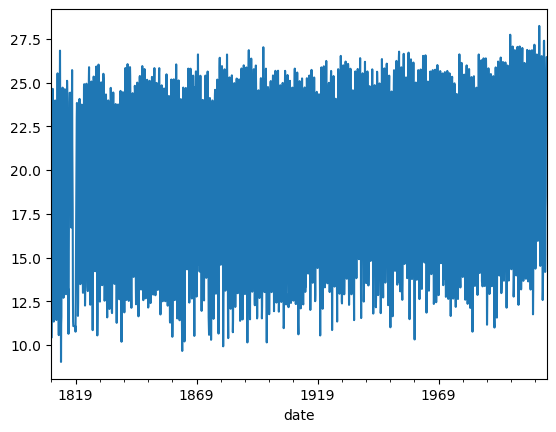

In [167]:
df.avg_temp.resample('M').mean().plot()

<AxesSubplot:xlabel='date'>

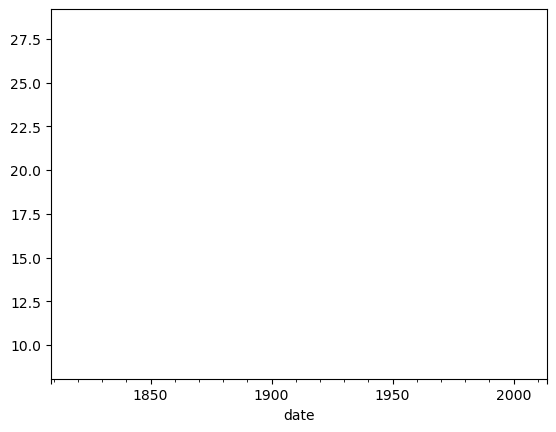

In [168]:
df.avg_temp.resample('D').mean().plot()

<AxesSubplot:xlabel='date'>

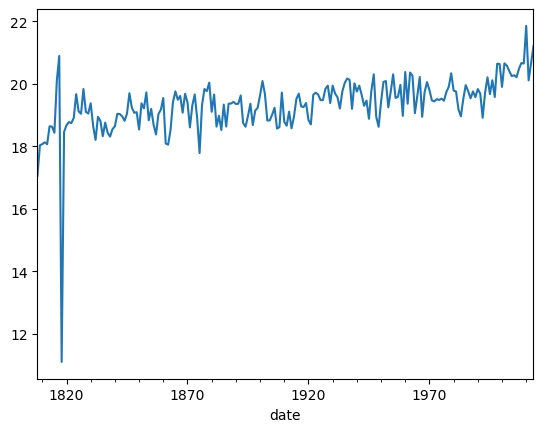

In [169]:
df.avg_temp.resample('Y').mean().plot()

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

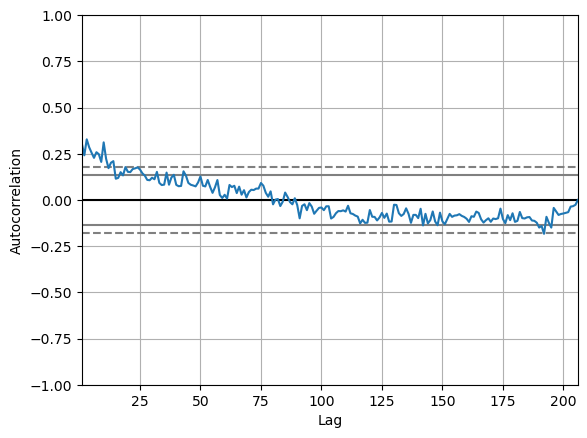

In [170]:
pd.plotting.autocorrelation_plot(df.avg_temp.resample('Y').mean())


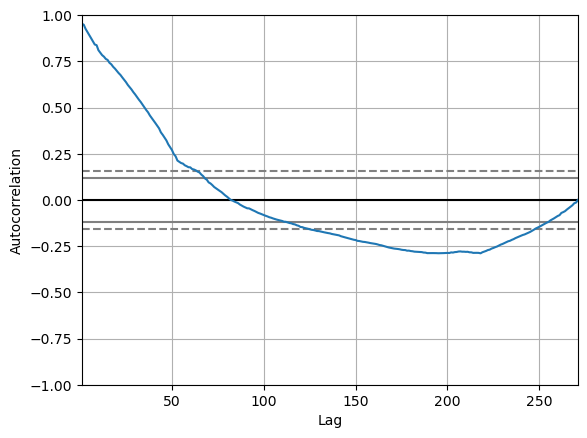

In [204]:
def clean_the_bat(df1):
    
    df= df1.ffill()
    
    df.rename(columns={'dt': 'date', 'AverageTemperature': 'avg_temp', 
                       'AverageTemperatureUncertainty': 'avg_uncertainty'}, inplace= True)
    df.columns= df.columns.str.lower()
    df['date']= pd.to_datetime(df['date'])
    
    df= df.set_index('date')
    
    pd.plotting.autocorrelation_plot(df.avg_temp.resample('Y').mean())
    return df
df= clean_the_bat(df1)

In [173]:
test_size=.90
val_size=.70
n= df.shape[0]
test_s_index=round(test_size * n)
val_s_index=round(val_size*n)

train= df[:val_start_index]
val= df[val_start_index:test_start_index]
test= df[test_start_index:]


print(train.shape, val.shape, test.shape)

(6019448, 6) (1719843, 6) (859921, 6)


In [174]:
train = df[:'1743']
val= df['1948':'1996']
test = df['1992':]


In [175]:
val_s_index

6019448

<AxesSubplot:xlabel='date'>

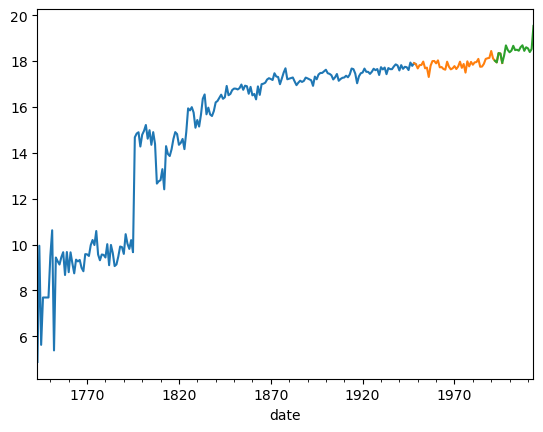

In [176]:
train['avg_temp'].resample('Y').mean().plot()
val['avg_temp'].resample('Y').mean().plot()
test['avg_temp'].resample('Y').mean().plot()


<AxesSubplot:xlabel='date'>

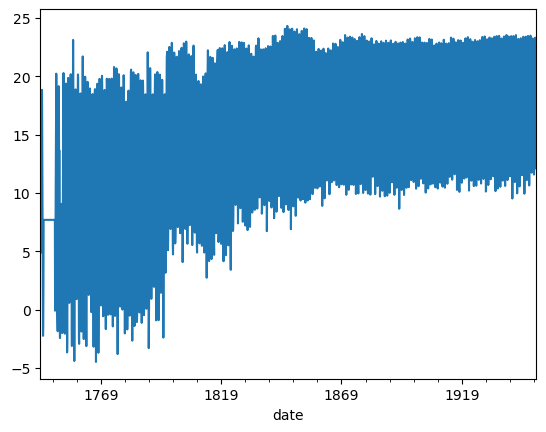

In [177]:
train['avg_temp'].resample('M').mean().plot()

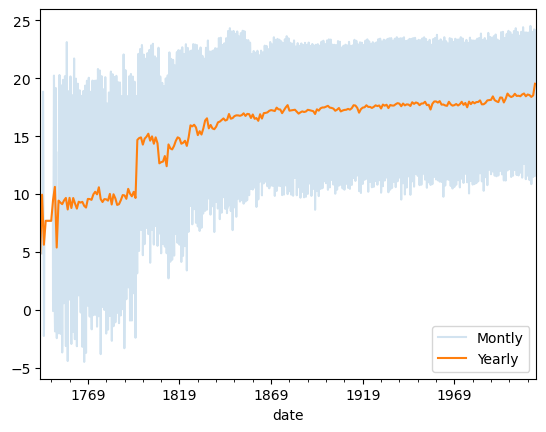

In [178]:
df['avg_temp'].resample('M').mean().plot(alpha= .20,label='Montly')
df['avg_temp'].resample('Y').mean().plot(label='Yearly')
plt.legend()

# modeling

In [179]:
def evaluate(target_var):
    '''
    This function will take the actual values of the target_var from validate, 
    and the predicted values stored in yhat_df, 
    and compute the rmse, rounding to 0 decimal places. 
    it will return the rmse. 
    '''
    rmse = round(mean_squared_error(val[target_var], yhat_df[target_var], squared=False), 5)
    return rmse

def plot_and_eval(target_var):
    '''
    This function takes in the target var name (string), and returns a plot
    of the values of train for that variable, validate, and the predicted values from yhat_df. 
    it will als lable the rmse. 
    '''
    plt.figure(figsize = (12,4))
    plt.plot(train[target_var], label='Train', linewidth=1, color='#377eb8')
    plt.plot(val[target_var], label='Validate', linewidth=1, color='#ff7f00')
    plt.plot(yhat_df[target_var], label='yhat', linewidth=2, color='#a65628')
    plt.legend()
    plt.title('Average Temperature')
    rmse = evaluate(target_var)
    print(target_var, '-- RMSE: {:.0f}'.format(rmse))
    plt.show()
    
def append_eval_df(model_type, target_var):
    '''
    this function takes in as arguments the type of model run, and the name of the target variable. 
    It returns the eval_df with the rmse appended to it for that model and target_var. 
    '''
    rmse = evaluate(target_var)
    d = {'model_type': [model_type], 'target_var': [target_var],
        'rmse': [rmse]}
    d = pd.DataFrame(d)
    return eval_df.append(d, ignore_index = True)

In [180]:
eval_df = pd.DataFrame(columns=['model_type', 'target_var', 'rmse'])
eval_df

Empty DataFrame
Columns: [model_type, target_var, rmse]
Index: []

## Last observation

In [181]:
train.head()

avg_temp  avg_uncertainty   city  country latitude longitude
date                                                                    
1743-11-01     6.068            1.737  Århus  Denmark   57.05N    10.33E
1743-12-01     6.068            1.737  Århus  Denmark   57.05N    10.33E
1744-01-01     6.068            1.737  Århus  Denmark   57.05N    10.33E
1744-02-01     6.068            1.737  Århus  Denmark   57.05N    10.33E
1744-03-01     6.068            1.737  Århus  Denmark   57.05N    10.33E

In [182]:
last =train['avg_temp'][-1:][0]

In [183]:
yhat_df = pd.DataFrame({'avg_temp': [last]},index= val.index)

yhat_df.head()

avg_temp
date                
1948-01-01     4.273
1948-02-01     4.273
1948-03-01     4.273
1948-04-01     4.273
1948-05-01     4.273

avg_temp -- RMSE: 17


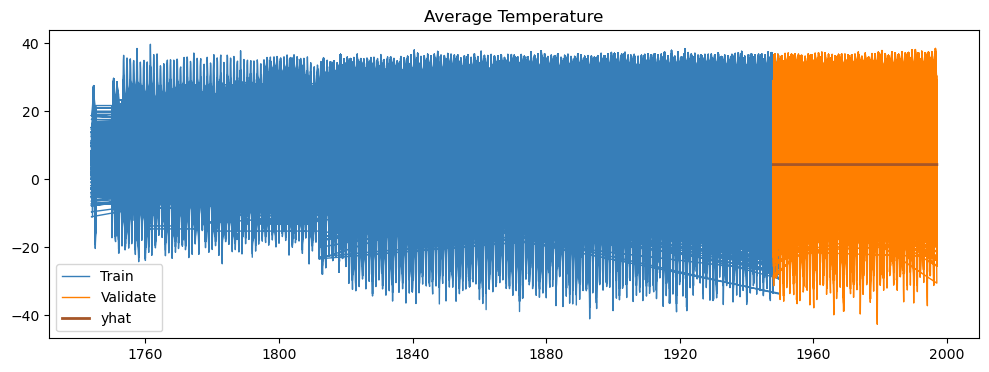

In [184]:
plot_and_eval('avg_temp')

In [185]:
eval_df = append_eval_df('last_observed', 'avg_temp')

eval_df

model_type target_var      rmse
0  last_observed   avg_temp  16.88887

### simple mean

In [186]:
avg= round(train['avg_temp'].mean(), 2)
avg

16.24

In [187]:
yhat_df = pd.DataFrame({'avg_temp': [avg]},index=val.index)

yhat_df.head()

avg_temp
date                
1948-01-01     16.24
1948-02-01     16.24
1948-03-01     16.24
1948-04-01     16.24
1948-05-01     16.24

avg_temp -- RMSE: 10


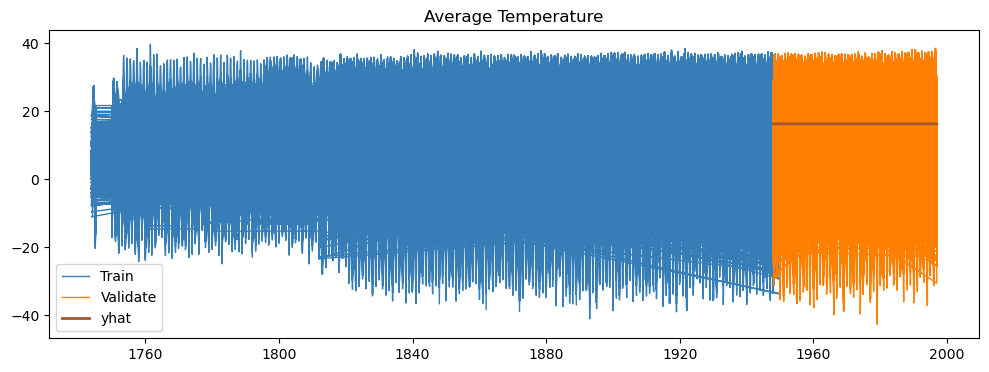

In [188]:
plot_and_eval('avg_temp')

In [201]:
train.shape

(5914062, 6)

In [200]:
train['avg_temp'].diff(25)

KeyboardInterrupt: 

In [191]:
yhat_df.shape

(2063880, 1)

In [192]:
val.shape

(2063880, 6)

In [193]:
yhat_df.index = val.index

avg_temp -- RMSE: 10


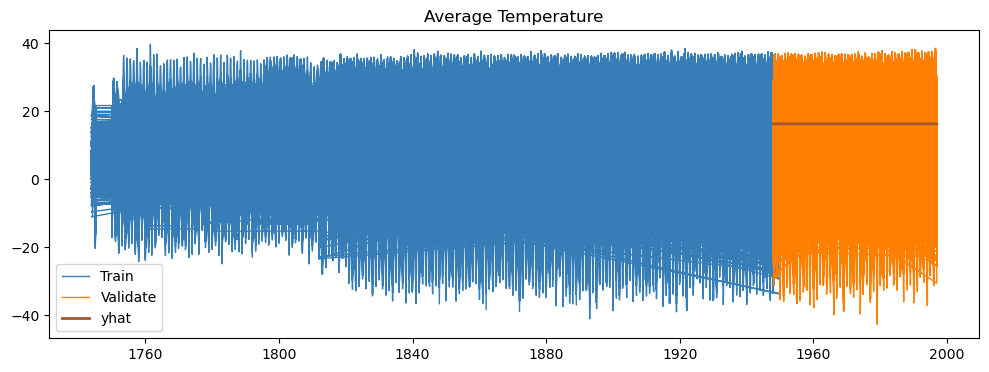

In [194]:
plot_and_eval('avg_temp')

### Forcast

In [196]:
future=future.reset_index()
future.head()

date  avg_temp  avg_uncertainty   city  country latitude longitude
0 2012-10-01     8.320            0.310  Århus  Denmark   57.05N    10.33E
1 2012-11-01     5.927            0.277  Århus  Denmark   57.05N    10.33E
2 2012-12-01    -0.921            0.394  Århus  Denmark   57.05N    10.33E
3 2013-01-01    -0.344            0.389  Århus  Denmark   57.05N    10.33E
4 2013-02-01    -0.390            0.240  Århus  Denmark   57.05N    10.33E

In [197]:
future['date']= future['date']+pd.DateOffset(years=1)
future.head()

date  avg_temp  avg_uncertainty   city  country latitude longitude
0 2013-10-01     8.320            0.310  Århus  Denmark   57.05N    10.33E
1 2013-11-01     5.927            0.277  Århus  Denmark   57.05N    10.33E
2 2013-12-01    -0.921            0.394  Århus  Denmark   57.05N    10.33E
3 2014-01-01    -0.344            0.389  Århus  Denmark   57.05N    10.33E
4 2014-02-01    -0.390            0.240  Århus  Denmark   57.05N    10.33E

In [198]:
future=future.set_index('date')
future.head()

avg_temp  avg_uncertainty   city  country latitude longitude
date                                                                    
2013-10-01     8.320            0.310  Århus  Denmark   57.05N    10.33E
2013-11-01     5.927            0.277  Århus  Denmark   57.05N    10.33E
2013-12-01    -0.921            0.394  Århus  Denmark   57.05N    10.33E
2014-01-01    -0.344            0.389  Århus  Denmark   57.05N    10.33E
2014-02-01    -0.390            0.240  Århus  Denmark   57.05N    10.33E

In [213]:
yhat_df=pd.DataFrame(future['avg_temp']+train['avg_temp'].diff(25).mean())

yhat_df

avg_temp
date                 
2012-10-01   8.320017
2012-11-01   5.927017
2012-12-01  -0.920983
2013-01-01  -0.343983
2013-02-01  -0.389983
2013-03-01  -0.473983
2013-04-01   5.514017
2013-05-01  12.770017
2013-06-01  15.223017
2013-07-01  18.259017
2013-08-01  17.423017
2013-09-01  17.423017
2012-10-01  18.487017
2012-11-01  13.084017
2012-12-01   6.143017
2013-01-01   6.021017
2013-02-01   7.478017
2013-03-01   9.346017
2013-04-01  13.163017
2013-05-01  19.443017
2013-06-01  21.758017
2013-07-01  23.920017
2013-08-01  25.246017
2013-09-01  25.246017
2012-10-01  14.466017
2012-11-01   7.934017
2012-12-01   2.486017
2013-01-01   1.539017
2013-02-01   4.612017
2013-03-01   6.846017
2013-04-01  11.092017
2013-05-01  17.070017
2013-06-01  19.056017
2013-07-01  20.736017
2013-08-01  21.452017
2013-09-01  21.452017
2012-10-01   3.968017
2012-11-01  -6.513983
2012-12-01 -21.320983
2013-01-01 -12.439983
2013-02-01 -14.448983
2013-03-01  -2.303983
2013-04-01   5.718017
2013-05-01  10.061017
2013-06-01  15.592017
2013-07-01  17.727017
2013-08-01  16.859017
2013-09-01  16.859017
2012-10-01   7.615017
2012-11-01  -3.948983
2012-12-01 -14.295983
2013-01-01 -13.557983
2013-02-01 -11.532983
2013-03-01   4.333017
2013-04-01  12.079017
2013-05-01  16.842017
2013-06-01  21.235017
2013-07-01  23.404017
2013-08-01  22.974017
2013-09-01  22.974017
2012-10-01  14.747017
2012-11-01  10.908017
2012-12-01  10.247017
2013-01-01   9.773017
2013-02-01   9.020017
2013-03-01  10.558017
2013-04-01  11.893017
2013-05-01  12.805017
2013-06-01  16.596017
2013-07-01  20.877017
2013-08-01  20.348017
2013-09-01  20.348017
2012-10-01   9.644017
2012-11-01   5.905017
2012-12-01   3.526017
2013-01-01   0.904017
2013-02-01   0.121017
2013-03-01   1.834017
2013-04-01   8.374017
2013-05-01  11.463017
2013-06-01  15.589017
2013-07-01  19.869017
2013-08-01  18.098017
2013-09-01  18.098017
2012-10-01   8.320017
2012-11-01   5.927017
2012-12-01  -0.920983
2013-01-01  -0.343983
2013-02-01  -0.389983
2013-03-01  -0.473983
2013-04-01   5.514017
2013-05-01  12.770017
2013-06-01  15.223017
2013-07-01  18.259017
2013-08-01  17.423017
2013-09-01  17.423017
2012-10-01  26.206017
2012-11-01  27.122017
2012-12-01  27.135017
2013-01-01  27.628017
2013-02-01  29.271017
2013-03-01  29.465017
2013-04-01  28.059017
2013-05-01  27.219017
2013-06-01  26.475017
2013-07-01  26.405017
2013-08-01  25.587017
2013-09-01  25.587017
2012-10-01  29.112017
2012-11-01  21.667017
2012-12-01  16.454017
2013-01-01  14.587017
2013-02-01  17.464017
2013-03-01  19.592017
2013-04-01  24.765017
2013-05-01  30.376017
2013-06-01  35.590017
2013-07-01  38.001017
2013-08-01  36.390017
2013-09-01  36.390017
2012-10-01  26.206017
2012-11-01  27.122017
2012-12-01  27.135017
2013-01-01  27.628017
2013-02-01  29.271017
2013-03-01  29.465017
2013-04-01  28.059017
2013-05-01  27.219017
2013-06-01  26.475017
2013-07-01  26.405017
2013-08-01  25.587017
2013-09-01  25.587017
2012-10-01   0.978017
2012-11-01  -7.985983
2012-12-01 -22.988983
2013-01-01 -19.923983
2013-02-01 -17.645983
2013-03-01  -5.888983
2013-04-01   3.713017
2013-05-01   8.701017
2013-06-01  14.904017
2013-07-01  17.814017
2013-08-01  16.636017
2013-09-01  16.636017
2012-10-01   7.889017
2012-11-01   4.380017
2012-12-01   1.075017
2013-01-01   0.011017
2013-02-01   2.883017
2013-03-01   4.892017
2013-04-01   6.899017
2013-05-01  11.405017
2013-06-01  13.915017
2013-07-01  16.810017
2013-08-01  16.605017
2013-09-01  15.252017
2012-10-01  26.463017
2012-11-01  27.399017
2012-12-01  26.807017
2013-01-01  27.766017
2013-02-01  29.198017
2013-03-01  29.605017
2013-04-01  28.641017
2013-05-01  27.797017
2013-06-01  26.702017
2013-07-01  25.532017
2013-08-01  25.132017
2013-09-01  25.132017
2012-10-01  26.207017
2012-11-01  27.582017
2012-12-01  27.418017
2013-01-01  28.136017
2013-02-01  29.679017
2013-03-01  29.531017
2013-04-01  27.879017
2013-05-01  26.956017
2013-06-01  25.809017
2013-07-01  25.206017
2013-08-01  24.156017
2013-09-01  24.156017
2012-10-0